In [1]:
from rascal.calibrator import Calibrator
from rascal.util import load_calibration_lines

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import json

from scipy.signal import find_peaks

C:\Users\Josh\AppData\Local\conda\conda\envs\astro\lib\site-packages\rascal\calibrator.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import pkg_resources
import pypeit

In this example, we'll calibrate a spectrum from the DEep Imaging Multi-Object Spectrograph (DEIMOS) instrument on Keck. We load an example calibration spectrum from the `pypeit` library:

In [32]:
data_path = pkg_resources.resource_filename("pypeit", "data/arc_lines/reid_arxiv/keck_deimos_830G.fits")

In [33]:
spectrum = fits.open(data_path)[1].data

This spectrum is from the 830G grating and contains Ne, Ar, Kr arc lines.

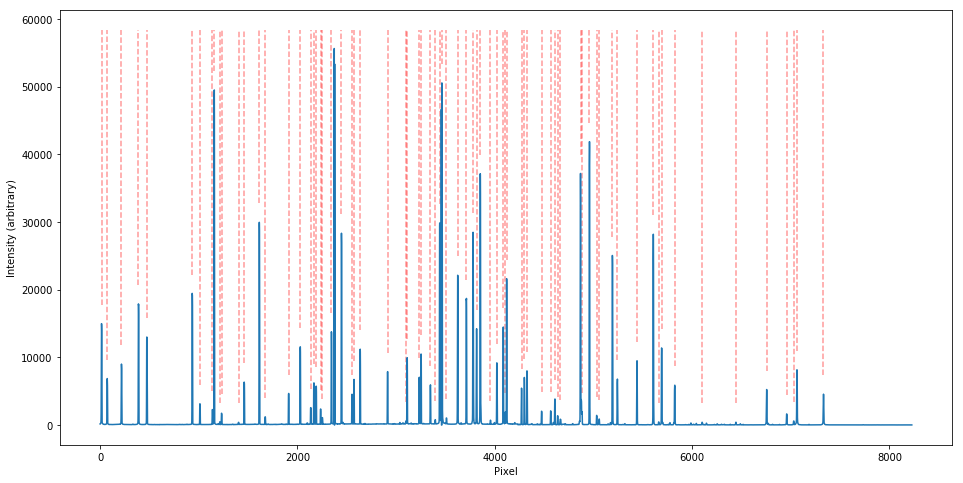

In [73]:
peaks, _ = find_peaks(spectrum['flux']-spectrum['flux'].min(), height=400, distance=10)

intensity_range = max(spectrum['flux']) - min(spectrum['flux'])
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot("110")
ax.plot(spectrum['flux'])
ax.vlines(peaks,
          spectrum['flux'][peaks.astype('int')]+0.05*intensity_range,
          max(spectrum['flux'])+0.05*intensity_range,
          linestyle='dashed',
          alpha=0.4,
          color='red')
plt.xlabel("Pixel")
plt.ylabel("Intensity (arbitrary)")
plt.show()

As this is a reference template, it also has the wavelengths per pixel which we can use to check our calibration solution.

In [60]:
spectrum['wave']

array([ 6501.7978497 ,  6502.25466559,  6502.7114885 , ...,
       10332.98391368, 10333.43598629, 10333.8880502 ])

We'll use this as a hint for the spectral range of the instrument (setting the min/max range). To present a more fair scenario, we pick an approximate min/max and set a tolerance of 500A.

As usual we tell rascal the number of pixels on the detector, a fit tolerance appropriate to the instrument (in this case, we set a slightly lower fit tolerance.

In [78]:
c = Calibrator(peaks, elements = ["Ne", "Ar", "Kr"],
                      min_wavelength=6500,
                      max_wavelength=10300)

c.set_fit_constraints(n_pix=len(spectrum), range_tolerance=200, fit_tolerance=10, polydeg=6)

best_p = c.fit()
print(best_p)


[-6.87427795e-21  1.65137085e-16 -1.54184867e-12  6.66364270e-09
 -1.17145095e-05  4.70927947e-01  6.49783597e+03]


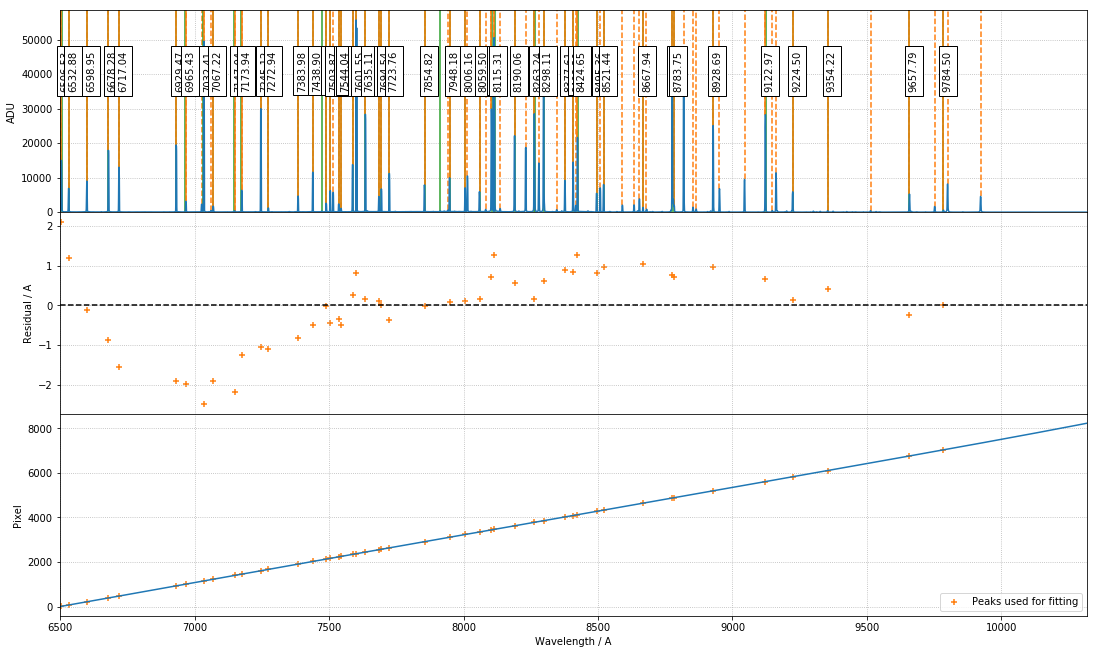

In [79]:
c.plot_fit(spectrum['flux'], best_p, plot_atlas=True)

Since we have an existing calibration, we can plot the fit residuals too:

In [80]:
x = c.polyval(best_p, np.arange(len(spectrum)))

In this case, pretty good - around 15A near the tails. This could be improved using a more appropriate model.

Text(0.5, 0, 'Pixel')

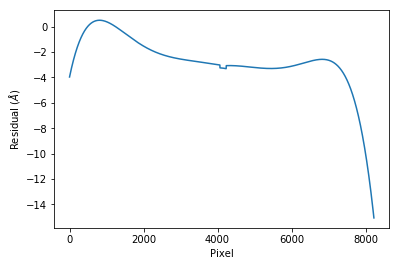

In [81]:
plt.plot(x-spectrum['wave'])
plt.ylabel("Residual ($\AA$)")
plt.xlabel("Pixel")